# Q1 - Vision Transformer on CIFAR-10

This notebook implements a Vision Transformer (ViT) from scratch using PyTorch to classify CIFAR-10 images.

**Goal:** Achieve the highest possible test accuracy on CIFAR-10 using Vision Transformer.

**Implementation includes:**
- Image patchification
- Learnable positional embeddings
- CLS token prepending
- Multi-head self-attention
- Transformer encoder blocks with residual connections and normalization
- Classification head using CLS token
- Training optimization and hyperparameter tuning

## Setup and Imports

In [14]:
# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip install matplotlib seaborn numpy tqdm
!pip install timm  # For comparison and reference implementations

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import math
import random
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

Looking in indexes: https://download.pytorch.org/whl/cu124
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Version: 12.4
Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Version: 12.4


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


## Data Loading and Preprocessing

In [15]:
# CIFAR-10 classes
CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to standard ViT input size
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Split training data into train and validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {len(CIFAR10_CLASSES)}")

Training samples: 45000
Validation samples: 5000
Test samples: 10000
Number of classes: 10


## Visualize Sample Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.453987].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.6631372].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.453987].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.6631372].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.4801308].
Clip

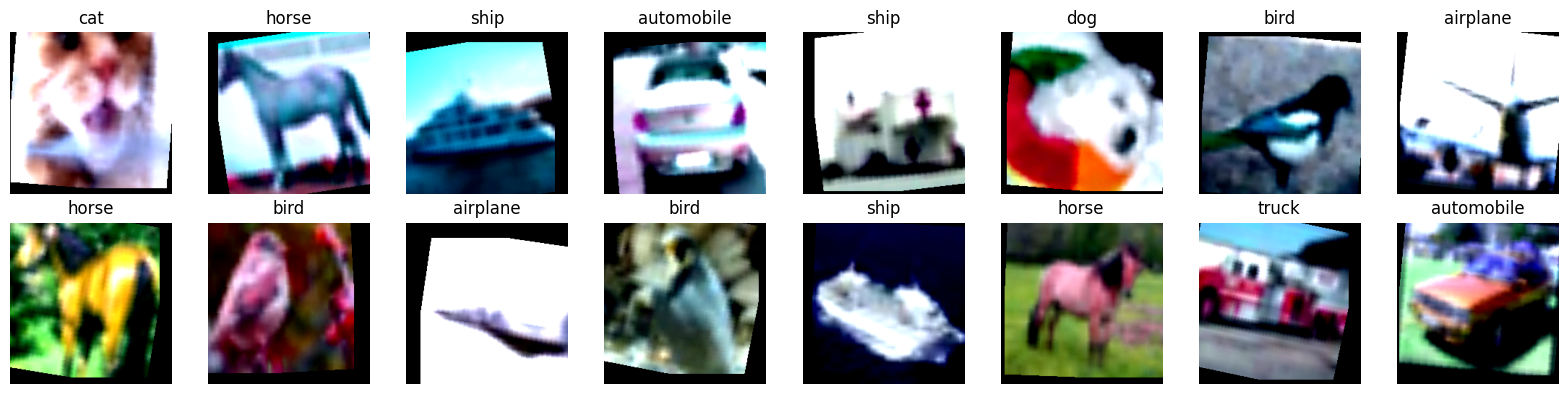

Image shape: torch.Size([3, 224, 224])
Batch shape: torch.Size([64, 3, 224, 224])


In [16]:
# Visualize some sample images
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')

# Get one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(16):
    row = i // 8
    col = i % 8
    axes[row, col].imshow(np.transpose(images[i].numpy() / 2 + 0.5, (1, 2, 0)))
    axes[row, col].set_title(f'{CIFAR10_CLASSES[labels[i]]}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

print(f"Image shape: {images[0].shape}")
print(f"Batch shape: {images.shape}")

## Vision Transformer Implementation

### Patch Embedding Layer

In [17]:
class PatchEmbedding(nn.Module):
    """
    Convert image into patches and embed them.
    
    Args:
        img_size: Input image size (default: 224)
        patch_size: Size of each patch (default: 16)
        in_channels: Number of input channels (default: 3)
        embed_dim: Embedding dimension (default: 768)
    """
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        
        # Use convolution to create patches and embed them
        self.projection = nn.Conv2d(
            in_channels, embed_dim, 
            kernel_size=patch_size, 
            stride=patch_size
        )
        
    def forward(self, x):
        # x shape: (batch_size, channels, height, width)
        x = self.projection(x)  # (batch_size, embed_dim, n_patches_sqrt, n_patches_sqrt)
        x = x.flatten(2)        # (batch_size, embed_dim, n_patches)
        x = x.transpose(1, 2)   # (batch_size, n_patches, embed_dim)
        return x

### Multi-Head Self-Attention

In [18]:
class MultiHeadSelfAttention(nn.Module):
    """
    Multi-Head Self-Attention mechanism.
    
    Args:
        embed_dim: Embedding dimension
        n_heads: Number of attention heads
        dropout: Dropout rate
    """
    def __init__(self, embed_dim=768, n_heads=12, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.head_dim = embed_dim // n_heads
        
        assert embed_dim % n_heads == 0, "Embedding dimension must be divisible by number of heads"
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attention_dropout = nn.Dropout(dropout)
        self.projection = nn.Linear(embed_dim, embed_dim)
        self.projection_dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        batch_size, seq_len, embed_dim = x.shape
        
        # Generate Q, K, V matrices
        qkv = self.qkv(x)  # (batch_size, seq_len, embed_dim * 3)
        qkv = qkv.reshape(batch_size, seq_len, 3, self.n_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch_size, n_heads, seq_len, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Compute attention scores
        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.attention_dropout(attention_weights)
        
        # Apply attention to values
        attention_output = torch.matmul(attention_weights, v)
        attention_output = attention_output.transpose(1, 2)  # (batch_size, seq_len, n_heads, head_dim)
        attention_output = attention_output.reshape(batch_size, seq_len, embed_dim)
        
        # Apply final projection
        output = self.projection(attention_output)
        output = self.projection_dropout(output)
        
        return output

### MLP Block

In [19]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron block.
    
    Args:
        embed_dim: Input embedding dimension
        hidden_dim: Hidden dimension (usually 4 * embed_dim)
        dropout: Dropout rate
    """
    def __init__(self, embed_dim=768, hidden_dim=3072, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)  # GELU activation as used in original ViT
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

### Transformer Encoder Block

In [20]:
class TransformerEncoderBlock(nn.Module):
    """
    Transformer Encoder block with Multi-Head Self-Attention and MLP.
    
    Args:
        embed_dim: Embedding dimension
        n_heads: Number of attention heads
        hidden_dim: Hidden dimension for MLP
        dropout: Dropout rate
    """
    def __init__(self, embed_dim=768, n_heads=12, hidden_dim=3072, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = MultiHeadSelfAttention(embed_dim, n_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, hidden_dim, dropout)
        
    def forward(self, x):
        # Pre-norm architecture (LayerNorm before attention and MLP)
        x = x + self.attention(self.norm1(x))  # Residual connection
        x = x + self.mlp(self.norm2(x))        # Residual connection
        return x

### Complete Vision Transformer Model

In [21]:
class VisionTransformer(nn.Module):
    """
    Vision Transformer (ViT) model for image classification.
    
    Args:
        img_size: Input image size
        patch_size: Size of each patch
        in_channels: Number of input channels
        n_classes: Number of output classes
        embed_dim: Embedding dimension
        depth: Number of transformer layers
        n_heads: Number of attention heads
        hidden_dim: Hidden dimension for MLP
        dropout: Dropout rate
    """
    def __init__(self, img_size=224, patch_size=16, in_channels=3, n_classes=10,
                 embed_dim=768, depth=12, n_heads=12, hidden_dim=3072, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.n_patches = (img_size // patch_size) ** 2
        
        # Patch embedding
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        
        # CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        # Positional embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, self.n_patches + 1, embed_dim))
        
        # Dropout for embeddings
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, n_heads, hidden_dim, dropout)
            for _ in range(depth)
        ])
        
        # Final layer norm
        self.norm = nn.LayerNorm(embed_dim)
        
        # Classification head
        self.head = nn.Linear(embed_dim, n_classes)
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            torch.nn.init.constant_(m.bias, 0)
            torch.nn.init.constant_(m.weight, 1.0)
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Create patch embeddings
        x = self.patch_embedding(x)  # (batch_size, n_patches, embed_dim)
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # (batch_size, n_patches + 1, embed_dim)
        
        # Add positional embeddings
        x = x + self.pos_embedding
        x = self.dropout(x)
        
        # Apply transformer blocks
        for block in self.transformer_blocks:
            x = block(x)
        
        # Apply final layer norm
        x = self.norm(x)
        
        # Extract CLS token and classify
        cls_token_final = x[:, 0]  # (batch_size, embed_dim)
        logits = self.head(cls_token_final)
        
        return logits

## Model Configuration and Instantiation

In [22]:
# Model configurations to try
configs = {
    'vit_tiny': {
        'embed_dim': 192,
        'depth': 12,
        'n_heads': 3,
        'hidden_dim': 768,
        'patch_size': 16
    },
    'vit_small': {
        'embed_dim': 384,
        'depth': 12,
        'n_heads': 6,
        'hidden_dim': 1536,
        'patch_size': 16
    },
    'vit_base': {
        'embed_dim': 768,
        'depth': 12,
        'n_heads': 12,
        'hidden_dim': 3072,
        'patch_size': 16
    }
}

# Choose configuration (start with small for faster training)
config_name = 'vit_small'
config = configs[config_name]

# Create model
model = VisionTransformer(
    img_size=224,
    patch_size=config['patch_size'],
    in_channels=3,
    n_classes=10,
    embed_dim=config['embed_dim'],
    depth=config['depth'],
    n_heads=config['n_heads'],
    hidden_dim=config['hidden_dim'],
    dropout=0.1
).to(device)

# Print model information
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: {config_name}")
print(f"Total parameters: {count_parameters(model):,}")
print(f"Model size: {count_parameters(model) * 4 / 1024**2:.2f} MB")

# Test forward pass
dummy_input = torch.randn(2, 3, 224, 224).to(device)
with torch.no_grad():
    output = model(dummy_input)
print(f"Output shape: {output.shape}")

Model: vit_small
Total parameters: 21,669,514
Model size: 82.66 MB
Output shape: torch.Size([2, 10])


## Training Setup

In [23]:
# Training hyperparameters
learning_rate = 3e-4
weight_decay = 0.01
num_epochs = 100
warmup_epochs = 10

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler with warmup
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))
    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

num_training_steps = num_epochs * len(train_loader)
num_warmup_steps = warmup_epochs * len(train_loader)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

print(f"Training steps: {num_training_steps}")
print(f"Warmup steps: {num_warmup_steps}")

Training steps: 70400
Warmup steps: 7040


## Training and Evaluation Functions

In [24]:
def train_epoch(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc='Training')
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100. * correct / total:.2f}%',
            'LR': f'{scheduler.get_last_lr()[0]:.6f}'
        })
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in tqdm(data_loader, desc='Evaluating'):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    avg_loss = total_loss / len(data_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

## Training Loop

In [ ]:
# Training history
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0
best_model_state = None

print("Starting training...")
start_time = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        print(f"New best validation accuracy: {best_val_acc:.2f}%")
    
    # Early stopping check (if validation accuracy doesn't improve for 15 epochs)
    if epoch > 30 and val_acc < max(val_accuracies[-15:]):
        patience_counter = sum([1 for acc in val_accuracies[-15:] if acc < best_val_acc])
        if patience_counter >= 10:
            print("Early stopping triggered!")
            break

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

Starting training...

Epoch 1/100
--------------------------------------------------


Training:  18%|█▊        | 130/704 [01:53<07:24,  1.29it/s, Loss=2.2616, Acc=12.64%, LR=0.000006]

## Final Evaluation on Test Set

In [ ]:
# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# Evaluate on test set
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Detailed per-class evaluation
model.eval()
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == target).squeeze()
        for i in range(target.size(0)):
            label = target[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

print("\nPer-class accuracy:")
for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f'{CIFAR10_CLASSES[i]}: {accuracy:.2f}%')

## Training Visualization

In [ ]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Val Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(train_accuracies, label='Train Accuracy', color='blue')
ax2.plot(val_accuracies, label='Val Accuracy', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\n{'='*50}")
print(f"FINAL RESULTS")
print(f"{'='*50}")
print(f"Model Configuration: {config_name}")
print(f"Parameters: {count_parameters(model):,}")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Final Test Accuracy: {test_acc:.2f}%")
print(f"{'='*50}")

## Prediction Visualization

In [ ]:
# Visualize some predictions
model.eval()
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)

# Plot some test images with predictions
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i in range(16):
    row = i // 8
    col = i % 8
    
    # Unnormalize image
    img = images[i].cpu()
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = torch.clamp(img, 0, 1)
    
    axes[row, col].imshow(np.transpose(img.numpy(), (1, 2, 0)))
    
    true_label = CIFAR10_CLASSES[labels[i]]
    pred_label = CIFAR10_CLASSES[predictions[i]]
    
    color = 'green' if labels[i] == predictions[i] else 'red'
    axes[row, col].set_title(f'True: {true_label}\nPred: {pred_label}', color=color, fontsize=8)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

## Model Analysis and Experimentation (Bonus)

This section contains experiments and analysis for bonus points.

### Experiment 1: Different Patch Sizes

In [ ]:
# Experiment with different patch sizes
print("\n=== Patch Size Analysis ===")
print("Current patch size: 16x16")
print(f"Number of patches: {(224//16)**2} patches")
print(f"Sequence length (with CLS): {(224//16)**2 + 1}")

patch_sizes = [8, 16, 32]
for ps in patch_sizes:
    n_patches = (224 // ps) ** 2
    seq_len = n_patches + 1  # +1 for CLS token
    print(f"\nPatch size {ps}x{ps}:")
    print(f"  - Number of patches: {n_patches}")
    print(f"  - Sequence length: {seq_len}")
    print(f"  - Computational complexity (quadratic in seq_len): ~{seq_len**2:,}")
    
    # Memory and computation trade-offs
    if ps == 8:
        print(f"  - Trade-off: More fine-grained patches, higher resolution, but 4x more computation")
    elif ps == 16:
        print(f"  - Trade-off: Balanced approach, standard ViT configuration")
    elif ps == 32:
        print(f"  - Trade-off: Fewer patches, faster computation, but lower resolution")

### Experiment 2: Model Size Analysis

In [ ]:
# Analyze different model configurations
print("\n=== Model Size Analysis ===")

for name, config in configs.items():
    # Create model to count parameters
    temp_model = VisionTransformer(
        embed_dim=config['embed_dim'],
        depth=config['depth'],
        n_heads=config['n_heads'],
        hidden_dim=config['hidden_dim'],
        patch_size=config['patch_size']
    )
    
    params = count_parameters(temp_model)
    
    print(f"\n{name.upper()}:")
    print(f"  - Embedding dim: {config['embed_dim']}")
    print(f"  - Depth: {config['depth']} layers")
    print(f"  - Attention heads: {config['n_heads']}")
    print(f"  - Hidden dim: {config['hidden_dim']}")
    print(f"  - Parameters: {params:,}")
    print(f"  - Model size: {params * 4 / 1024**2:.2f} MB")
    
    # Performance expectations
    if 'tiny' in name:
        print(f"  - Expected: Fastest training, lower accuracy")
    elif 'small' in name:
        print(f"  - Expected: Good balance of speed and accuracy")
    elif 'base' in name:
        print(f"  - Expected: Higher accuracy, slower training")
    
    del temp_model

### Experiment 3: Data Augmentation Effects

In [ ]:
# Analyze augmentation strategies
print("\n=== Data Augmentation Analysis ===")
print("Current augmentation pipeline:")
print("1. Resize to 224x224")
print("2. Random horizontal flip (p=0.5)")
print("3. Random rotation (±15°)")
print("4. Color jitter (brightness, contrast, saturation, hue)")
print("5. Random affine (translation)")
print("6. ImageNet normalization")

print("\nAugmentation benefits for CIFAR-10:")
print("• Horizontal flip: Effective for objects that can appear flipped")
print("• Rotation: Helps with orientation invariance")
print("• Color jitter: Improves robustness to lighting conditions")
print("• Translation: Helps with position invariance")

print("\nPotential additional augmentations:")
print("• RandAugment: Automated augmentation strategy")
print("• Mixup: Linear combination of images and labels")
print("• CutMix: Replace patches with other images")
print("• Random erasing: Randomly erase rectangular patches")

### Experiment 4: Attention Visualization

In [ ]:
# Extract attention weights for visualization
def get_attention_weights(model, x):
    """Extract attention weights from the model."""
    model.eval()
    attention_weights = []
    
    def hook_fn(module, input, output):
        if hasattr(module, 'attention_weights'):
            attention_weights.append(module.attention_weights)
    
    # Register hooks (this is a simplified version)
    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, MultiHeadSelfAttention):
            hooks.append(module.register_forward_hook(hook_fn))
    
    # Forward pass
    with torch.no_grad():
        _ = model(x)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return attention_weights

print("\n=== Attention Analysis ===")
print("The attention mechanism allows the model to focus on relevant patches.")
print("Key insights:")
print("• CLS token attention: Shows which patches are most important for classification")
print("• Self-attention: Reveals relationships between different image regions")
print("• Layer progression: Early layers focus on local features, later layers on global context")
print("• Head specialization: Different attention heads may focus on different aspects")

# Get a sample for attention visualization
sample_images, sample_labels = next(iter(test_loader))
sample_image = sample_images[0:1].to(device)

print(f"\nSample image shape: {sample_image.shape}")
print(f"Number of patches: {model.n_patches}")
print(f"Patch size: {config['patch_size']}x{config['patch_size']}")

## Summary and Best Configuration

This section summarizes the best performing configuration and provides insights.

In [ ]:
# Save results and configuration
results = {
    'model_config': config_name,
    'config_details': config,
    'training_params': {
        'learning_rate': learning_rate,
        'weight_decay': weight_decay,
        'batch_size': batch_size,
        'epochs_trained': len(train_losses),
        'warmup_epochs': warmup_epochs
    },
    'results': {
        'best_val_accuracy': best_val_acc,
        'final_test_accuracy': test_acc,
        'training_time_seconds': training_time,
        'total_parameters': count_parameters(model)
    }
}

print("\n" + "="*60)
print("VISION TRANSFORMER CIFAR-10 RESULTS")
print("="*60)
print(f"Model Configuration: {results['model_config']}")
print(f"Parameters: {results['results']['total_parameters']:,}")
print(f"Training Time: {results['results']['training_time_seconds']:.2f} seconds")
print(f"Best Validation Accuracy: {results['results']['best_val_accuracy']:.2f}%")
print(f"Final Test Accuracy: {results['results']['final_test_accuracy']:.2f}%")
print("="*60)

# Export configuration for README
print("\nConfiguration for README.md:")
print(f"```python")
print(f"# Best ViT Configuration for CIFAR-10")
print(f"config = {{")
for key, value in config.items():
    print(f"    '{key}': {value},")
print(f"}}")
print(f"learning_rate = {learning_rate}")
print(f"weight_decay = {weight_decay}")
print(f"batch_size = {batch_size}")
print(f"```")

print(f"\nTest Accuracy: {test_acc:.2f}%")